## Rule-Based with NER(+ POS) Implementation

### Initial Preprocessing 

We initially start by separating the raw data into smaller phrases based on empirically validated common separators. We can use a more generic "strong" separation schema which utilizes the Counter class, a specialized dictionary subclass designed for counting hashable objects, or a "weak" separation containing some general phrase separators. Empirically "weak" separation is better tailored towards our data.

In [ ]:
import pandas as pd
from collections import Counter
import re


def split_keep_phrases_dynamic(text, separation='weak'):
    if not text or not isinstance(text, str):
        return []  # Return an empty list for invalid or empty input

    # Identify non-alphanumeric separators (escaping used for handling re symbols)
    if separation == 'strong':
        # More general separation using collection of separators
        separators = ''.join([re.escape(char) for char, _ in Counter(text).items() if not char.isalnum() and char.strip()])
    else:
        # Weaker separation based on the data
        separators_list = '/&,()' # Regarding commas we follow the convnetion on the CLEAN_TEXT labels and not of the example i.e., we separate the writer
        separators = ''.join([re.escape(char) for char in separators_list if not char.isalnum() and char.strip()])

    # Debugging: Log separators to ensure they're valid
    if not separators:
        print(f"No valid separators found in: {text}")
        return [text.strip()]  # Return the original text as a single phrase

    try:
        # Build regex to split on these separators (excluding spaces)
        regex = f"[{separators}]+"
        
        # Split the text while keeping phrases together
        parts = re.split(regex, text)
        return [part.strip() for part in parts if part.strip()]
    except re.error as e:
        # Log regex error for debugging
        print(f"Regex error with separators '{separators}' for text: {text}. Error: {e}")
        return [text.strip()]  # Return the original text as a fallback



# Read the  file
file_path = "data/raw/normalization_assesment_dataset_10k.csv"
df = pd.read_csv(file_path)

# Apply the splitting function to the 'raw_comp_writers_text' column
df['split_phrases'] = df['raw_comp_writers_text'].apply(lambda x: split_keep_phrases_dynamic(x,separation='weak') if pd.notnull(x) else [])

# Save the updated DataFrame to a new  file
output_file_path = "data/processed_data.csv" 
df.to_csv(output_file_path, index=False)
print(f"Processed data has been saved to {output_file_path}")


Processed data has been saved to data/processed_data.csv


We split the data into train, val and test. Next we create a histogram to identify most common words which we can potentially remove (e.g., Unknown, copyright, control, etc).  To do this we ONLY use train data. In essence this part is the training equivalent of this script. As we will use pre-trained models (rules based on the words of the histogram, ner/pos spacy models), from here on out we practically perform inference.

c:\Users\konni\venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


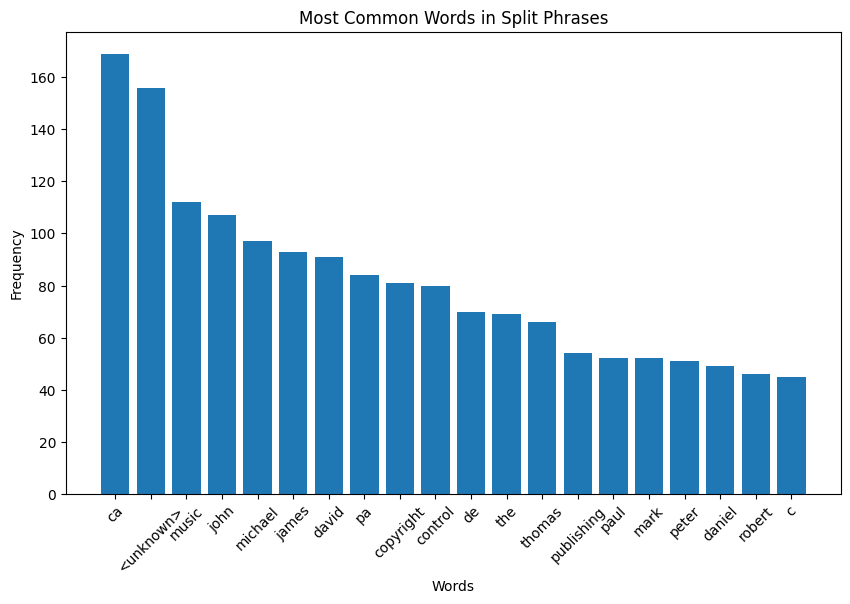

Processed data has been saved to data/processed_data_train.csv
Processed data has been saved to data/processed_data_val.csv
Processed data has been saved to data/processed_data_test.csv


In [ ]:
import pandas as pd
from collections import Counter
import ast
import matplotlib.pyplot as plt
import numpy as np
import random

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Step 1: Read the CSV
df = pd.read_csv("data/processed_data.csv") 

# Step 2: Convert strings of lists into actual lists
df["split_phrases"] = df["split_phrases"].apply(ast.literal_eval)

# Split into train, val, test
train_df, val_df, test_df = np.split(df.sample(frac=1, random_state=42), 
                                     [int(0.5 * len(df)), int(0.75 * len(df))])

# Step 3: Flatten the lists of phrases into a single list of words
all_words = [word for phrases in train_df["split_phrases"] for phrase in phrases for word in phrase.lower().split()]

# Step 4: Count word frequencies
word_counts = Counter(all_words)

# Step 5: Get the most common words
most_common_words = word_counts.most_common(20)  # Top 10 most common words
words, counts = zip(*most_common_words)

# Step 6: Create a histogram
plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.title("Most Common Words in Split Phrases")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

# We save the split dfs
output_file_path = "data/processed_data_train.csv" 
train_df.to_csv(output_file_path, index=False)
print(f"Processed data has been saved to {output_file_path}")

output_file_path = "data/processed_data_val.csv" 
val_df.to_csv(output_file_path, index=False)
print(f"Processed data has been saved to {output_file_path}")

output_file_path = "data/processed_data_test.csv" 
test_df.to_csv(output_file_path, index=False)
print(f"Processed data has been saved to {output_file_path}")


Then we filter non-writer keywords, and non-latin character words

In [5]:
import pandas as pd
import ast
import re

# Example filtering keywords that indicate non-writer entities, based on manual inspection of the histogram of words:
NON_WRITER_KEYWORDS = [
    "unknown", "copyright", "control", "publishing", "music", "records",
    "ca","pa", "ltd", "universal", "warner", "sony", "ascap", "writer"
]


# Step 1: Read the CSV
df = pd.read_csv("data/processed_data_test.csv")  
df["split_phrases"] = df["split_phrases"].apply(ast.literal_eval)

# Remove the non-name words from all phrases in 'split_phrases'
def remove_non_name_words(phrases):
    updated_phrases = []
    for phrase in phrases:
        filtered_phrase = " ".join(word for word in phrase.split() if word.lower() not in NON_WRITER_KEYWORDS)
        if filtered_phrase:  # Only add non-empty phrases
            updated_phrases.append(filtered_phrase)
    return updated_phrases

capital_diacritics = 'ÄÖÜÆØÅÉÈÊËÁÀÂÍÌÎÓÒÔÚÙÛÑÇÝŸŒĐŁØÙÃÕÑȘȚĂÎÂȚÁÓ'
lowercase_diacritics = 'äöüßæøåéèêëáàâíìîóòôúùûñçýÿœđłøùãõñșțăîâțáóảâấầậẵẽếệếặỉơợệớửựắấăằắằẳặẽẵảẻẻễđăếệêửươăặịảẵẩảứửắ'
special_chars = '@$'
regex_extended_latin=f"[^a-zA-Z0-9\\s.,;:'\"()\\[\\]!?\\-–—{capital_diacritics}{lowercase_diacritics}{special_chars}]+"
def keep_general_latin_and_punctuation_with_case(phrases, regex):
    """
    Keeps English characters, extended Latin-based characters (including uppercase),
    and common punctuation. Removes all other characters.

    Args:
        text (str): The input text.

    Returns:
        str: Cleaned text with Latin-based characters (uppercase and lowercase) and punctuation.
    """
    updated_phrases = []
    for phrase in phrases:
        updated_phrase = re.sub(regex, "", phrase)
        if updated_phrase:
            updated_phrases.append(updated_phrase)
    return updated_phrases

# function to merge list of phrases into  "phrase1/phrase2/..." format
def merge_text(phrases):
    if not phrases or not isinstance(phrases, list):
        return "" 
    return  "/".join(phrases)

# Apply the function to the 'split_phrases' column
# We use apply for clarity and expecting it to be faster than for loop
df["preproc_phrases"] = df["split_phrases"].apply(lambda x: keep_general_latin_and_punctuation_with_case(x,regex_extended_latin) if x!=[] else [])
df["preproc_phrases"] = df["preproc_phrases"].apply(remove_non_name_words)
# We also create a column with the preprocessed phrases in output format (merged with '/') for evaluation
df["PREPROC_OUT"] = df["preproc_phrases"].apply(merge_text)


# Save the updated DataFrame
output_file_path = "data/processed_data_test.csv"  
df.to_csv(output_file_path, index=False)


# Check the updated DataFrame
print(df["preproc_phrases"].head())

0                                     [Laurie Berkner]
1                                            [convolk]
2                               [Jaylin Javon Luckett]
3    [Jon Bon Jovi, Desmond Child, Richie Sambora, ...
4             [Jerry Finn, Mark Hoppus, Travis Barker]
Name: preproc_phrases, dtype: object


### NER: 

Use Spacy and perform Named entity recognition and identify names ("PERSON" label in spacy's ner component). SpaCy's en_core_web_trf pipeline utilizes the roberta-base (https://arxiv.org/abs/1907.11692) transformer model as its underlying architecture. As such the ner component uses this transformer as its encoder (https://spacy.io/models/en).

This is a high precision/low recall operation (With some leeway depending on r[0] we drop phrases with no names from the ner component). As such, depending on our use case we can choose to either drop completely or handle cases that are droped from the ner component. Based on this in the case where the ner filter fails we either drop (handler="drop") or handle the droped phrase using the pos component (handler="pos"). In the later case, we accept  phrases with nouns, proper nouns or adjectives on the handler.

As we saw in README.md, we can alternatively change the handler and use an LLM through api calls instead of pos, and also hyperparameter tune on the validation set based on our requirements.

In [11]:
import spacy
import time
import pandas as pd
import ast

# Load spaCy's English language model
spacy.require_gpu()
nlp = spacy.load("en_core_web_trf")


def filter_phrases_with_names_batch(phrases_list, r, handler="drop"):
    results = []
    # Process all phrases in the list as a batch and keep enabled only the ner component, 
    # for efficient processing based on https://spacy.io/usage/processing-pipelines
    docs = list(nlp.pipe(phrases_list))  #disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]))  # Batch process phrases with spaCy
    for i, doc in enumerate(docs):
        phrase = phrases_list[i]
        words = phrase.split()
        num_words = len(words)
        
        # Count "PERSON" entities in the processed doc
        num_names = sum(1 for ent in doc.ents if ent.label_ == "PERSON")
        
        # Check if the percentage of names meets the threshold
        if num_words > 0 and (num_names / num_words) >= r[0]:
            results.append(phrase)
        else:
            if handler == 'pos':
                num_nouns = sum(1 for token in doc if token.pos_ == "PROPN"  or token.pos_ == "NOUN" or token.pos_ == "ADJ" or token.pos_ == "INTJ")
                if num_words > 0 and (num_nouns / num_words) >= r[1]:
                    results.append(phrase)
    return results


# Step 1: Read the CSV
df = pd.read_csv("data/processed_data_test.csv") 
df["preproc_phrases"] = df["preproc_phrases"].apply(ast.literal_eval)


handler = "drop"
# Apply the function to the 'preproc_phrases' column
r = (0.25, 0.25)  # Replace with your desired percentage thresholds (e.g., 50%)
start_time=time.time()
s=str(r)if handler == "pos" else f"({str(r[0])})"
df[f"ner_phrases_{handler}_{s}"] = df["preproc_phrases"].apply(lambda phrases: filter_phrases_with_names_batch(phrases, r, handler=handler))
df[f"NER_OUT_{handler}_{s}"] = df[f"ner_phrases_{handler}_{s}"].apply(merge_text)
print("Time to execute:",time.time()-start_time)

# Save the updated DataFrame to a new Excel file
output_file_path = "data/processed_data_test.csv"  
df.to_csv(output_file_path, index=False)

# Check the updated DataFrame
print(df.head())


c:\Users\konni\venv\Lib\site-packages\thinc\shims\pytorch.py:261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filelike, map_location=devic

Time to execute: 30.423441648483276
                               raw_comp_writers_text  \
0                                     Laurie Berkner   
1                                           ​convolk   
2                               Jaylin Javon Luckett   
3  Jon Bon Jovi/Desmond Child/Richie Sambora/Bruc...   
4               Jerry Finn/Mark Hoppus/Travis Barker   

                                          CLEAN_TEXT  \
0                                     Laurie Berkner   
1                                           ​convolk   
2                               Jaylin Javon Luckett   
3  Jon Bon Jovi/Desmond Child/Richie Sambora/Bruc...   
4               Jerry Finn/Mark Hoppus/Travis Barker   

                                       split_phrases  \
0                                 ['Laurie Berkner']   
1                                  ['\u200bconvolk']   
2                           ['Jaylin Javon Luckett']   
3  ['Jon Bon Jovi', 'Desmond Child', 'Richie Samb...   
4     ['Je

Note: If we want to run things faster we maybe need to swithch to numpy. Also blue and edit distance calculations during evaluation are inefficient.